<span style="font-size: 18px;"><b> A/B testing. </span></b>

## Project description

**Goal:** create recommendations for revenue growth in an internet shop based on results of A/B testing.

**Project Includes** the following key phases:
- Data Exploration and Preprocessing.
- A/B Test Reliability Evaluation.
- Exploratory Data Analysis.
- Data Preparation for Hypothesis Testing.
- Hypothesis Testing with Statistical Methods: Mann-Whitney U-cryterion, confidence interval.

**Data Overview:**  

**Orders:**  
    `transactionId` — unique order ID;  
    `visitorId` — the ID of the user who made the order;  
    `date` — date of the order;  
    `revenue` — total revenue from the order;  
    `group` — A/B test group where the order was placed.  
    
**Visitors:**  
    `date` — date;  
    `group` — A/B test group;  
    `visitors` — number of visitors for the A/B test group on the date.

## Data import

### Importing libraries, configuring the environment, data import

In [66]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [67]:
#формат вещественных чисел в таблицах
pd.set_option('display.float_format', '{:.2f}'.format)

#разрешение графиков получше
%config InlineBackend.figure_format = 'retina'

#убираем ворнинги
import warnings
warnings.filterwarnings("ignore")

Data import. Parsing dates in date format. Renaming columns.

In [68]:
orders = pd.read_csv('.../a_b_orders.csv', parse_dates=['date'])
orders.columns = orders.columns.str.replace('Id', '_id')

In [69]:
visitors = pd.read_csv('.../a_b_visitors.csv', parse_dates=['date'])

### Preprocessing

Checking the quality of data - missing values, duplicates, anomalies.

In [70]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [71]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [72]:
orders.duplicated().sum() + visitors.duplicated().sum()

0

In [73]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [74]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [75]:
orders['date'].agg(['min', 'max'])

min   2019-08-01
max   2019-08-31
Name: date, dtype: datetime64[ns]

In [76]:
visitors['date'].agg(['min', 'max'])

min   2019-08-01
max   2019-08-31
Name: date, dtype: datetime64[ns]

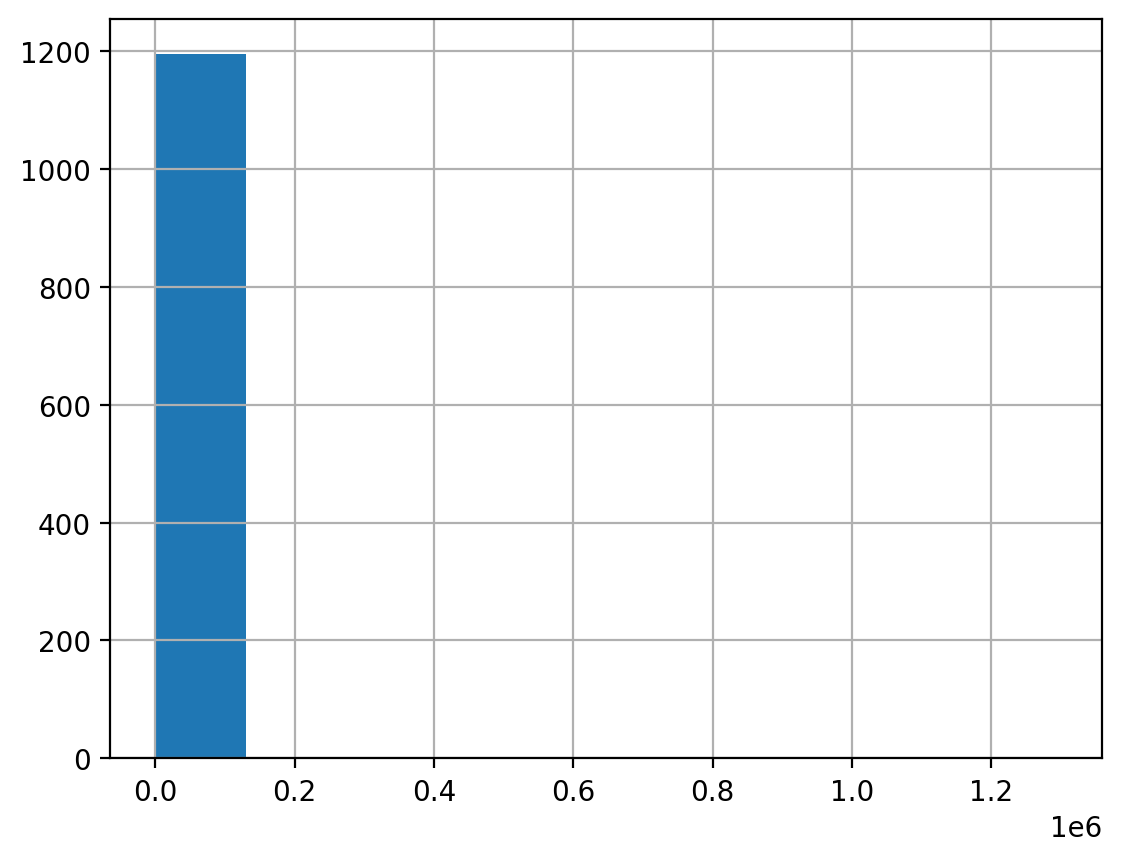

In [77]:
orders['revenue'].hist();

Looks like we will have to deal with outliers.  
For now let's look closer.

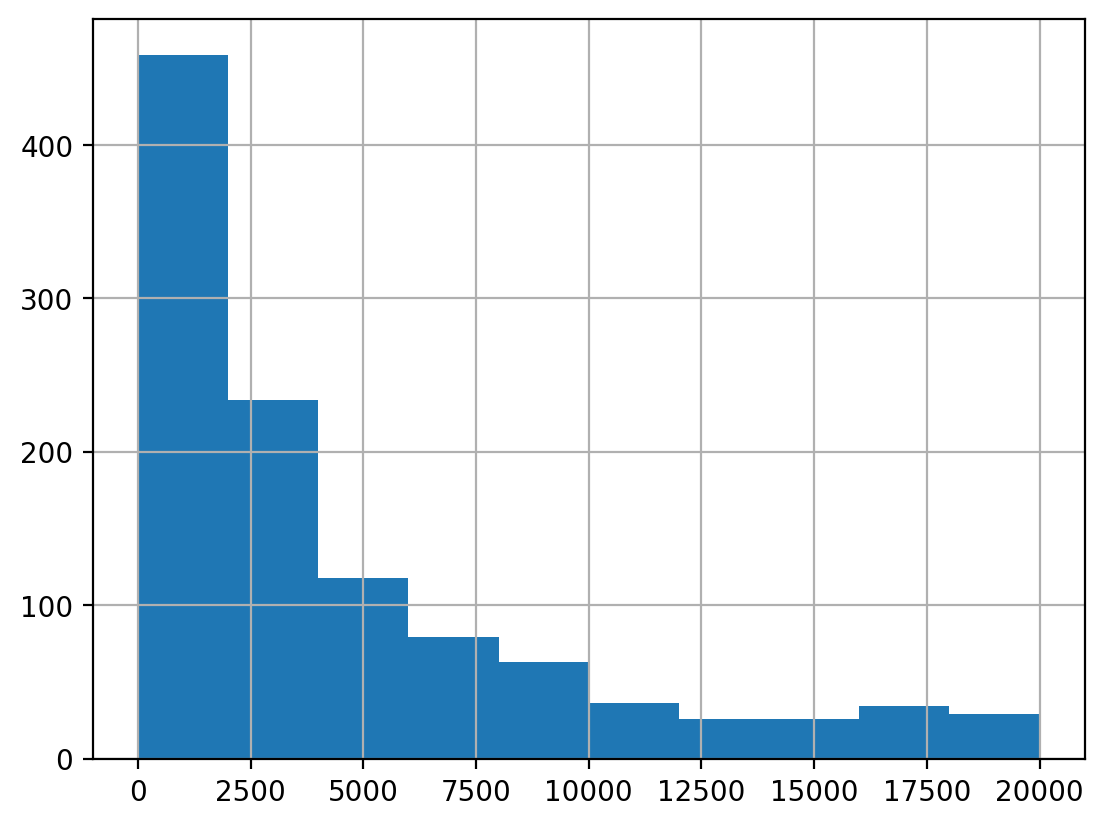

In [78]:
orders['revenue'].hist(range=(0, 20000));

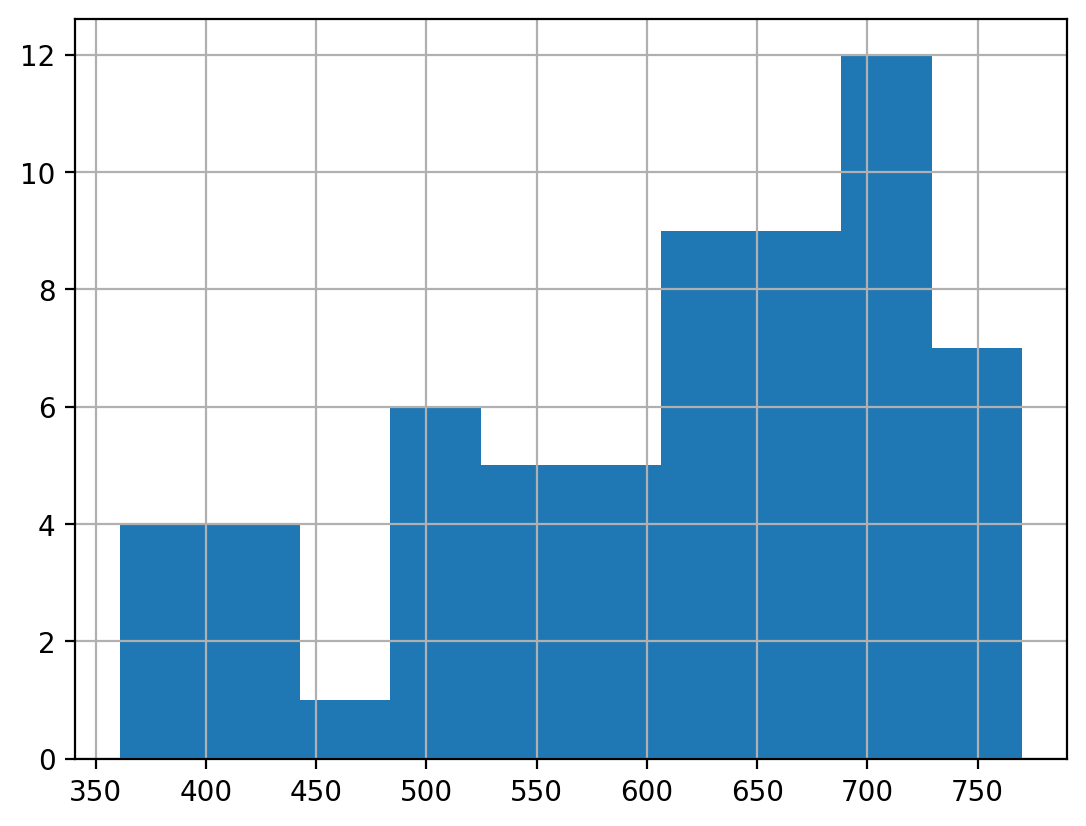

In [79]:
visitors['visitors'].hist();

### A/B Test Reliability Evaluation

Checking group sizes to make sure there is no much difference.

In [80]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

This will do.  

Let's check if we have users that were placed to both groups.

In [81]:
ab_users = orders.query('group == "A"').merge(orders.query('group == "B"')
                                   , on='visitor_id'
                                   , suffixes=['_a', '_b'])[['visitor_id', 'date_a', 'date_b']]
ab_users_ = ab_users['visitor_id'].drop_duplicates()
ab_users_.count()

58

In [82]:
ab_users_.count() / orders['visitor_id'].nunique()

0.05625606207565471

58 users (about 6% of buyers).  
Let's check how many orders these users made.

In [83]:
orders.query('visitor_id in @ab_users_').shape[0]

181

In [84]:
orders.query('visitor_id in @ab_users_').shape[0] / orders.shape[0]

0.15121136173767752

15% of orders were made by users who were incorrectly placed. We will need to exclude them as they may distort the interpretation of the A/B test results.
Let's remove them from the `orders` table and, at the very least, exclude the visits when they made orders from the `visitors` table (as we have no information about their other visits, let's assume they are still present and could influence the results).

In [85]:
orders = orders.query('visitor_id not in @ab_users_')

In [86]:
#counting incorrectly placed users that were added as visitors for every date in each group
a_users = ab_users[['visitor_id', 'date_a']].drop_duplicates().groupby('date_a')['visitor_id'].nunique().reset_index()
b_users = ab_users[['visitor_id', 'date_b']].drop_duplicates().groupby('date_b')['visitor_id'].nunique().reset_index()

#adding columns to `visitors` table
a_users.columns = ['date', 'a_visitors']
b_users.columns = ['date', 'b_visitors']
a_users['group'] = 'A'
b_users['group'] = 'B'
visitors = visitors.merge(a_users, on=['date', 'group'], how='left').merge(b_users, on=['date', 'group'], how='left')

#subtracting, removing unnecessary columns
visitors.fillna(0, inplace=True)
visitors['visitors'] = (visitors['visitors'] - visitors['a_visitors'] - visitors['b_visitors']).astype(int)
visitors.drop(['a_visitors', 'b_visitors'], axis=1, inplace=True)

### Summary  

We have data on the daily number of visitors and purchases of individual visitors for August 2019 for groups A and B.  
No preprocessing required - there are no duplicates, empty values, or obvious anomalies in the data.  
We may need to handle outliers for `revenue` in the `orders` table.   

A/B test reliability evaluation:
- The group sizes are approximately equal - everything is fine with the test here.  
- There are about 6% of users who made about 15% of purchases that were placed in both groups. Since this affects the correctness of the A/B test results, the purchases of these users, as well as the visits we know about, have been removed from the `orders` and `visitors` tables, despite being a significant portion of the data.  
- In the visitors table, there may still be visitors incorrectly counted in both groups who did not make purchases at the time of the visit. It is impossible to track this with the available data.

## Exploratory analysis

Cumulative revenue by group.

In [87]:
cum_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum()
cum_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum()

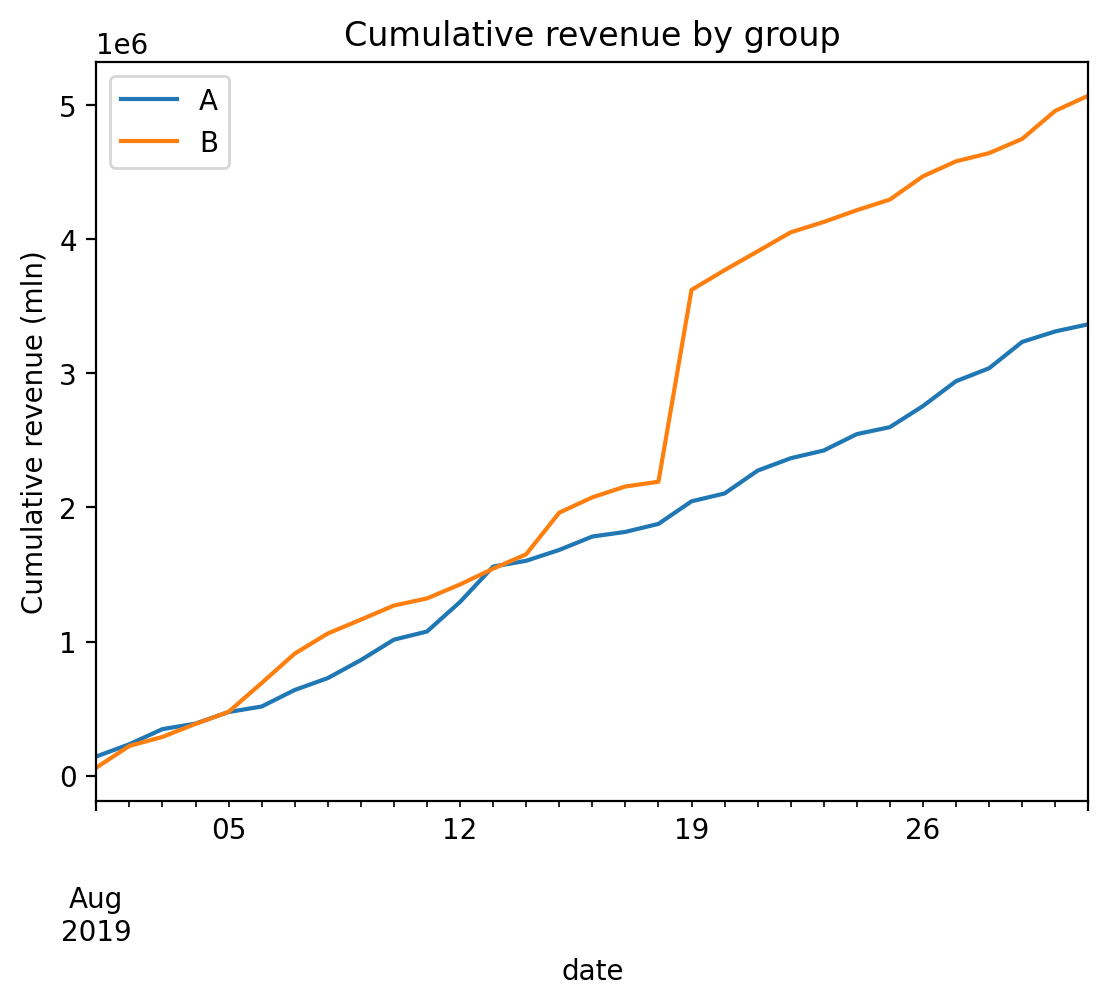

In [88]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Cumulative revenue by group')
plt.ylabel('Cumulative revenue (mln)')
plt.show()

It appears that we need to address at least one significant outlier, as it distorts the analysis(not so obvious visually, where will be the line for group B without it - higher or lower than A). Therefore, before examining cumulative metrics, let's work with the outliers first.

### Outliers

#### Revenue

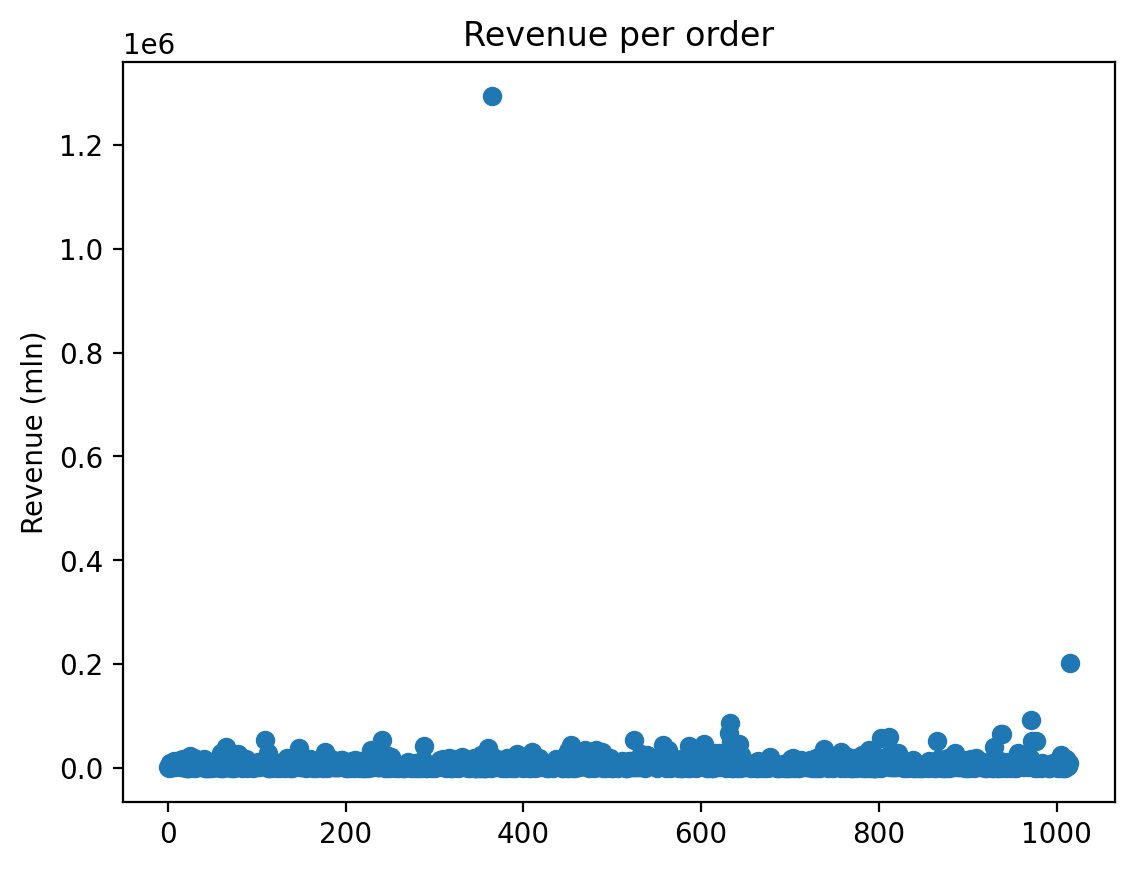

In [89]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Revenue per order')
plt.ylabel('Revenue (mln)');

We have obvious outliers but anyway let's look closer.

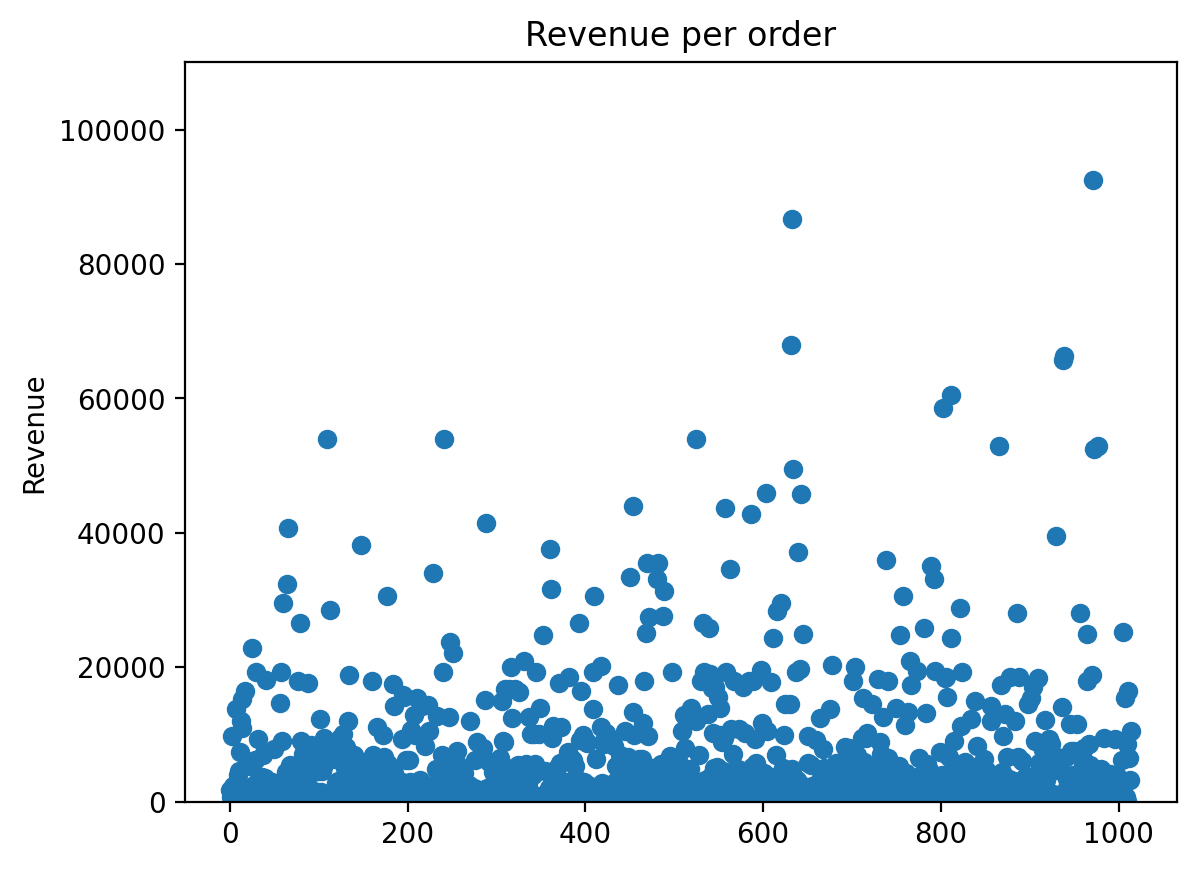

In [90]:
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 110000)
plt.title('Revenue per order')
plt.ylabel('Revenue');

Checking 0.95 and 0.99 percentiles.

In [91]:
orders['revenue'].quantile([0.95, 0.99])

0.95   26785.00
0.99   53904.00
Name: revenue, dtype: float64

Creating a list of users who made unusually expensive orders (using the 0.95 percentile).

In [92]:
filtered_revenue = orders.query('revenue > 26785')['visitor_id'].unique()

#### Orders per buyer

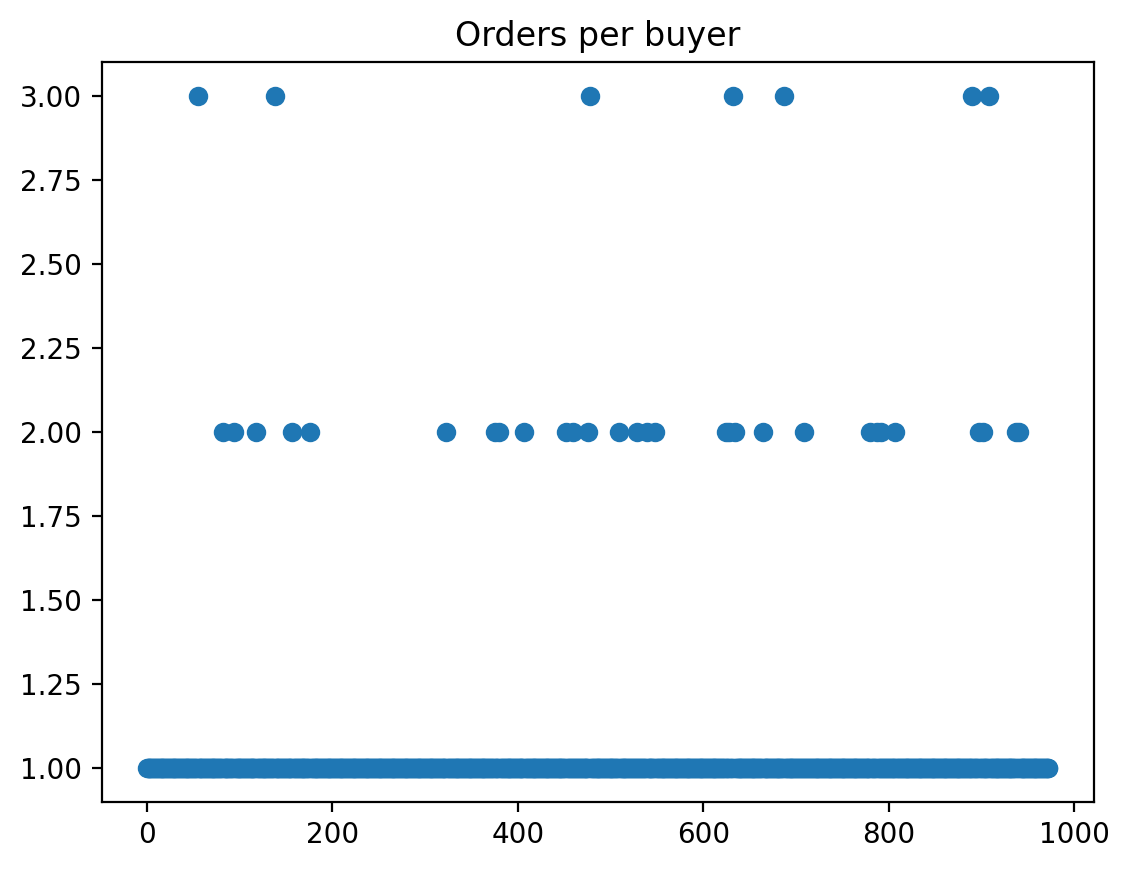

In [93]:
orders_per_buyer = orders.groupby('visitor_id')['revenue'].count()
x_values = pd.Series(range(0, len(orders_per_buyer)))
plt.scatter(x_values, orders_per_buyer)
plt.title('Orders per buyer');

Not so significant outliers, but we can still list the users who ordered more than 2 times. Let's check it's about 0.99 percentile.

In [94]:
orders_per_buyer.quantile([0.95, 0.99])

0.95   1.00
0.99   2.00
Name: revenue, dtype: float64

In [95]:
filtered_orders = orders_per_buyer[orders_per_buyer > 2].index

Combining into one list users who performed unusual actions, such as making numerous purchases or buying expensive items.

In [96]:
filtered_orders = pd.Series(filtered_orders, name='user_id')
filtered_revenue = pd.Series(filtered_revenue, name='user_id')
filtered_users = pd.concat([filtered_orders, filtered_revenue]).drop_duplicates()

Let's check which part of data we will filter this way.

In [97]:
'{0:.2%}'.format(filtered_users.count() / orders['visitor_id'].nunique())

'5.96%'

In [98]:
orders = orders.query('visitor_id not in @filtered_users')

### Cumulative metrics

#### Cumulative revenue by group

In [99]:
cum_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum()
cum_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum()

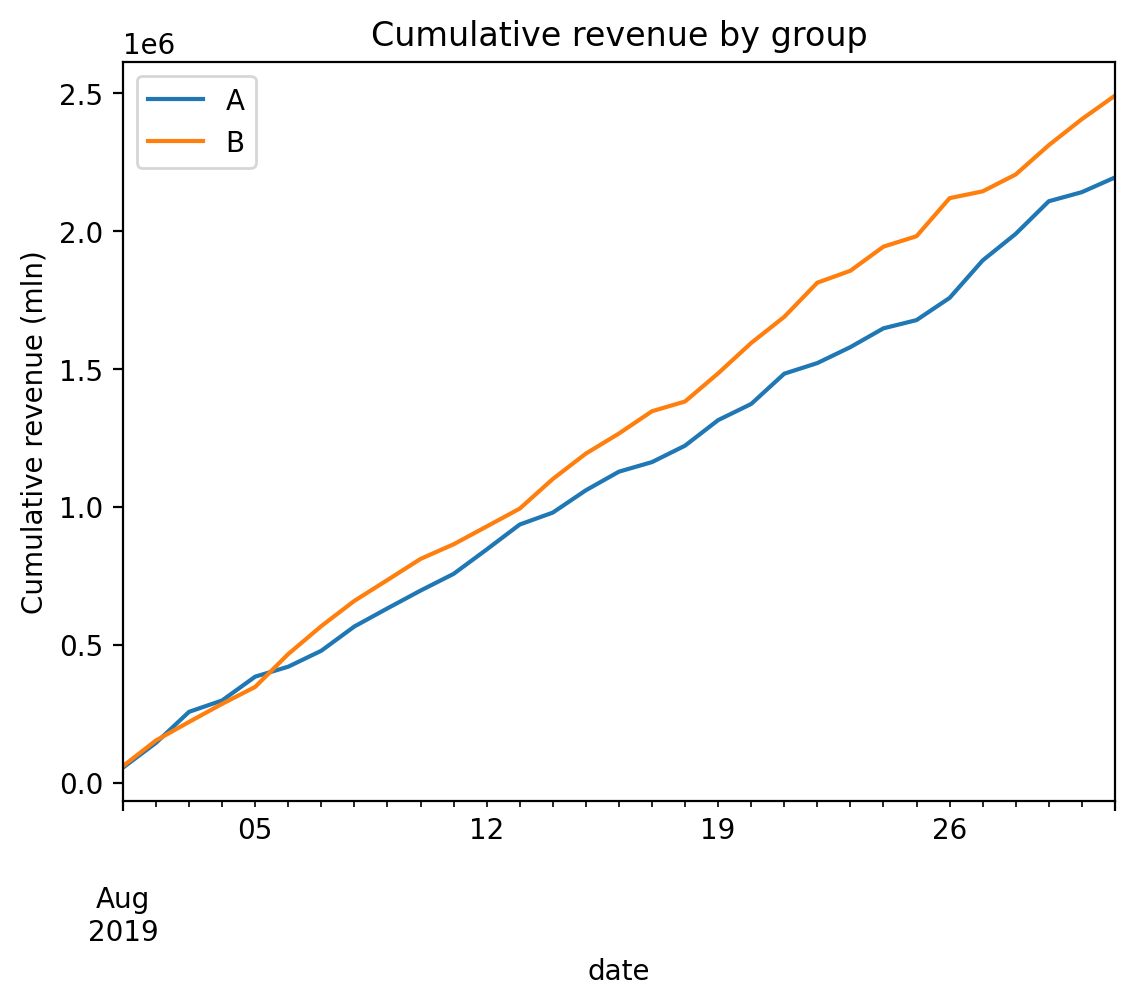

In [100]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Cumulative revenue by group')
plt.ylabel('Cumulative revenue (mln)')
plt.show()

Looks more evident this way.  
Now we need to find out what contributes to the fact that the cumulative revenue for group B is consistently higher. To do this, let's examine what happens with the average check and the number of purchases per visitor in each group.

#### Cumulative average check by group

In [101]:
avg_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum() \
                       / orders.query('group == "A"').groupby('date')['revenue'].count().cumsum()

avg_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum() \
                       / orders.query('group == "B"').groupby('date')['revenue'].count().cumsum()

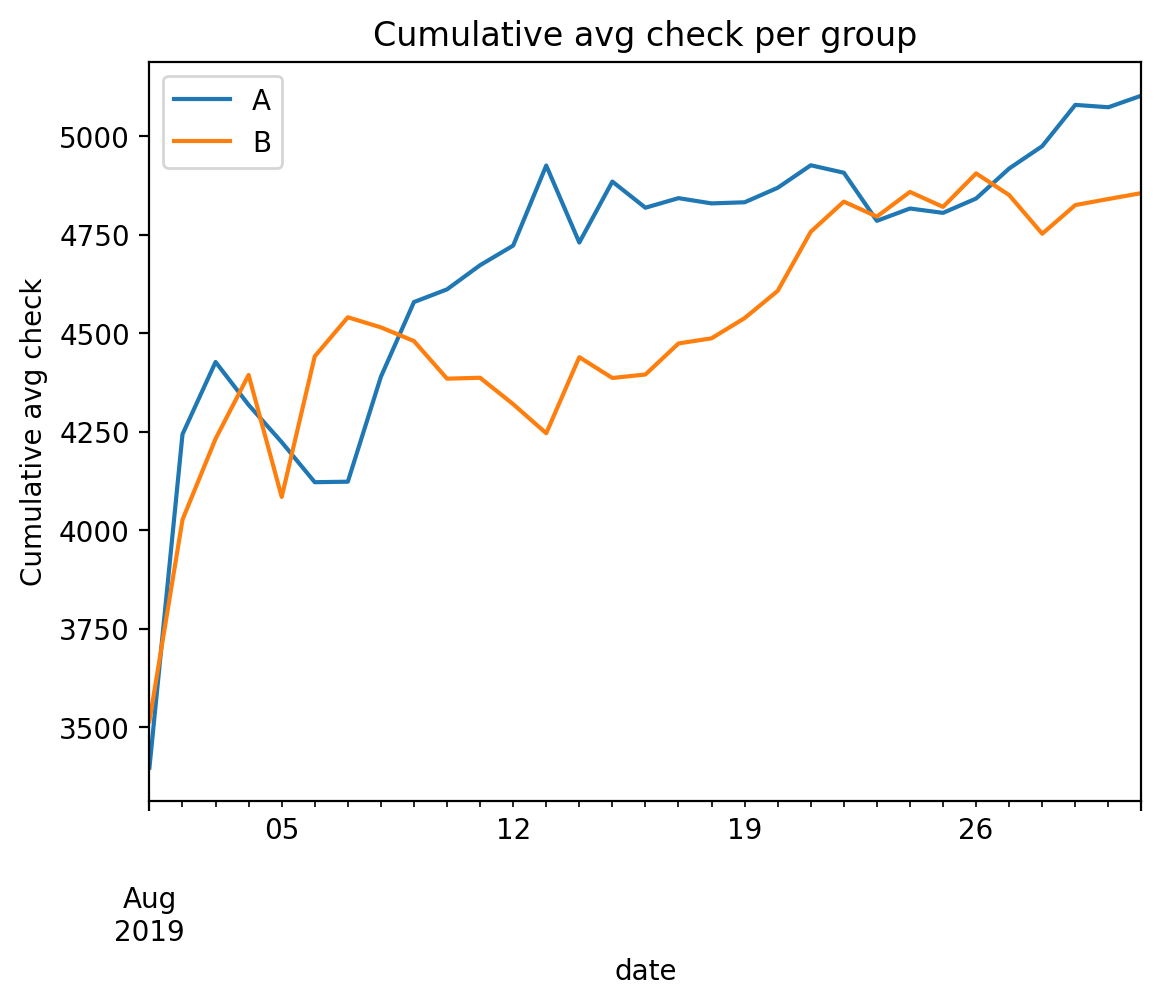

In [102]:
avg_revenue_a.plot(label='A')
avg_revenue_b.plot(label='B')
plt.legend()
plt.title('Cumulative avg check per group')
plt.ylabel('Cumulative avg check')
plt.show()

This one doesn't look like the reason of group B cumulative revenue superiority.  

Let's look at the relative change from group A to group B.

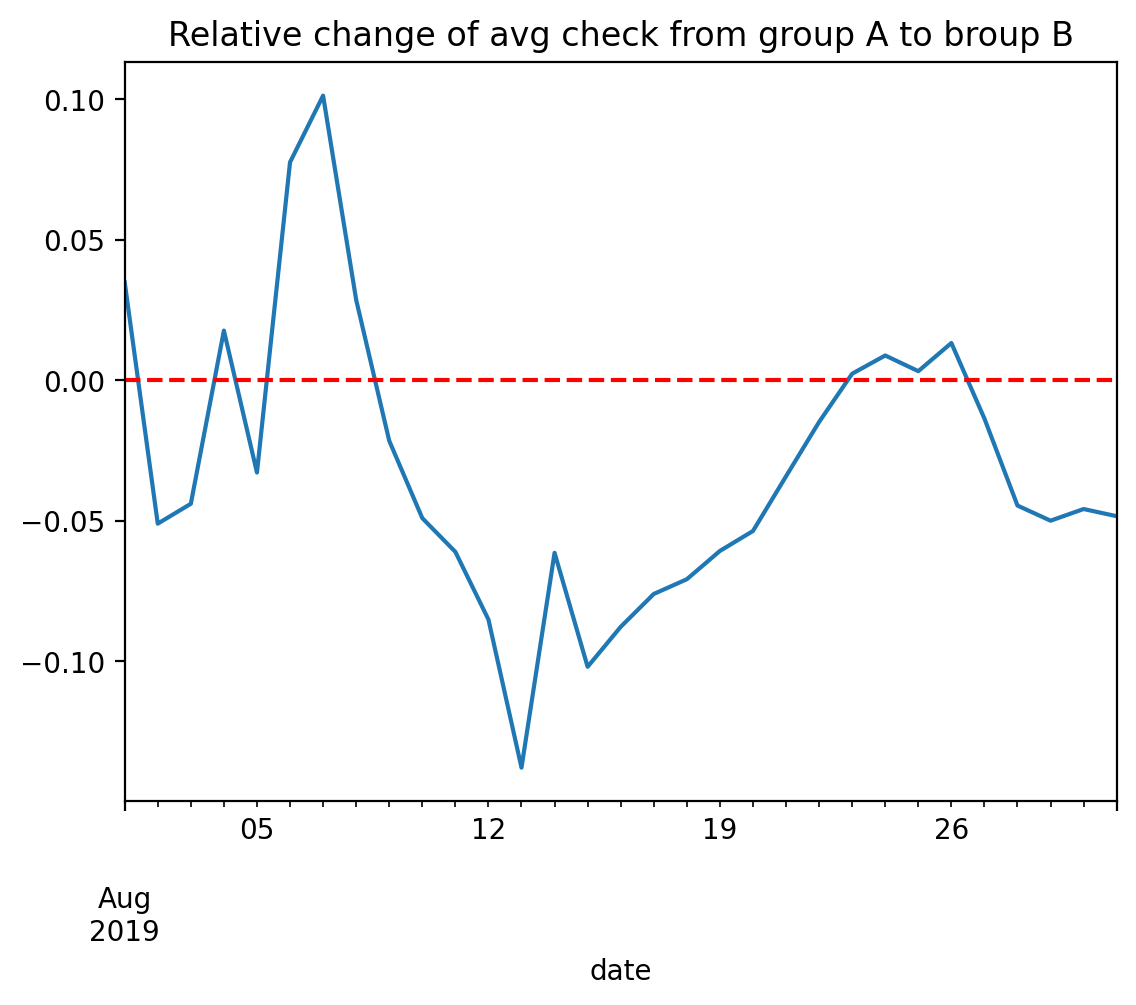

In [103]:
(avg_revenue_b / avg_revenue_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Relative change of avg check from group A to broup B');

Doesn't really look promising.

#### Cumulative average orders per visitor by group

In [104]:
avg_orders_a = orders.query('group == "A"').groupby('date')['revenue'].count().cumsum() \
               / visitors.query('group == "A"').groupby('date')['visitors'].first().cumsum()

avg_orders_b = orders.query('group == "B"').groupby('date')['revenue'].count().cumsum() \
               / visitors.query('group == "B"').groupby('date')['visitors'].first().cumsum()

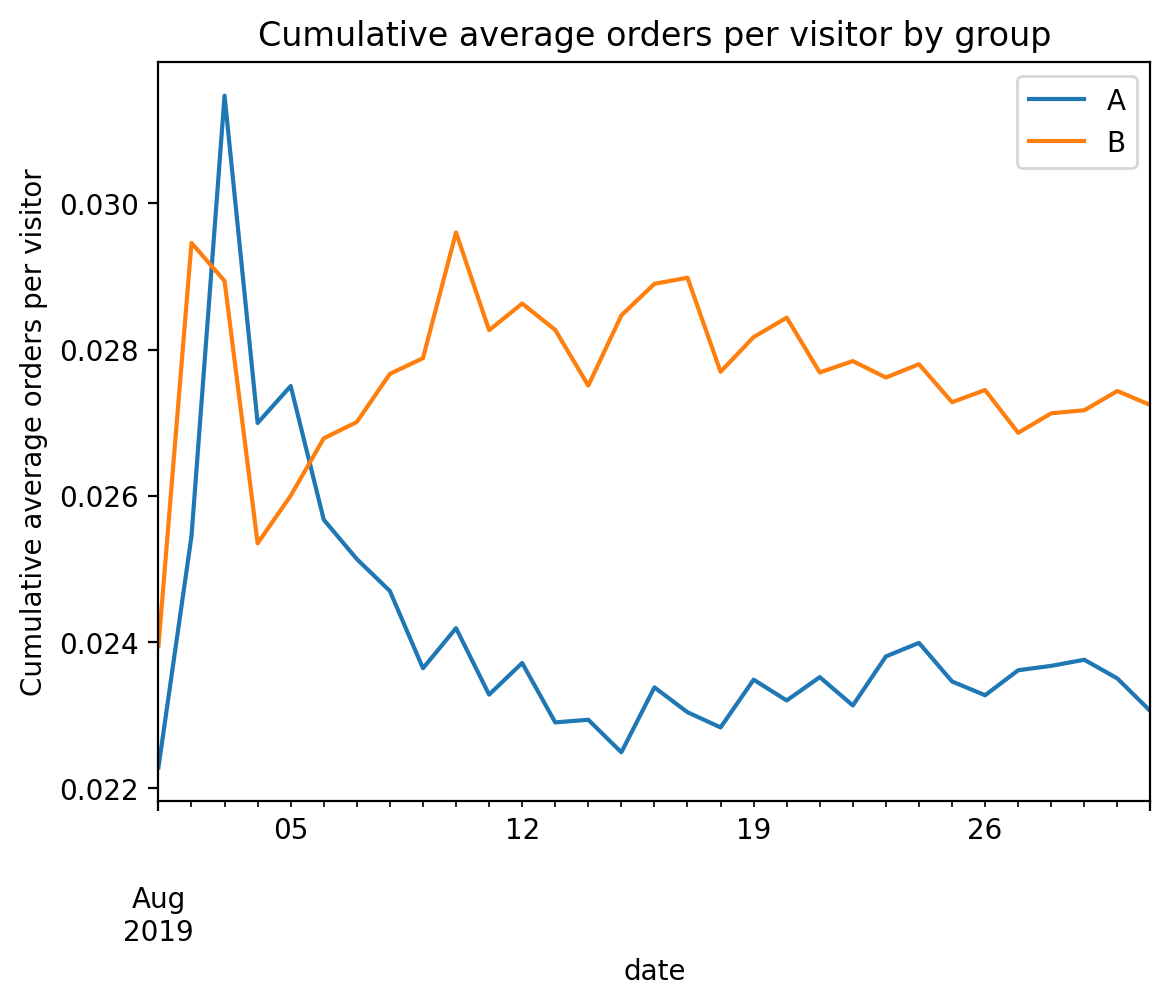

In [105]:
avg_orders_a.plot(label='A')
avg_orders_b.plot(label='B')
plt.legend()
plt.title('Cumulative average orders per visitor by group')
plt.ylabel('Cumulative average orders per visitor')
plt.show()

It seems that this is the cause: the average orders per visitor in group B consistently surpass those in group A.

This becomes even more apparent when examining the relative change.

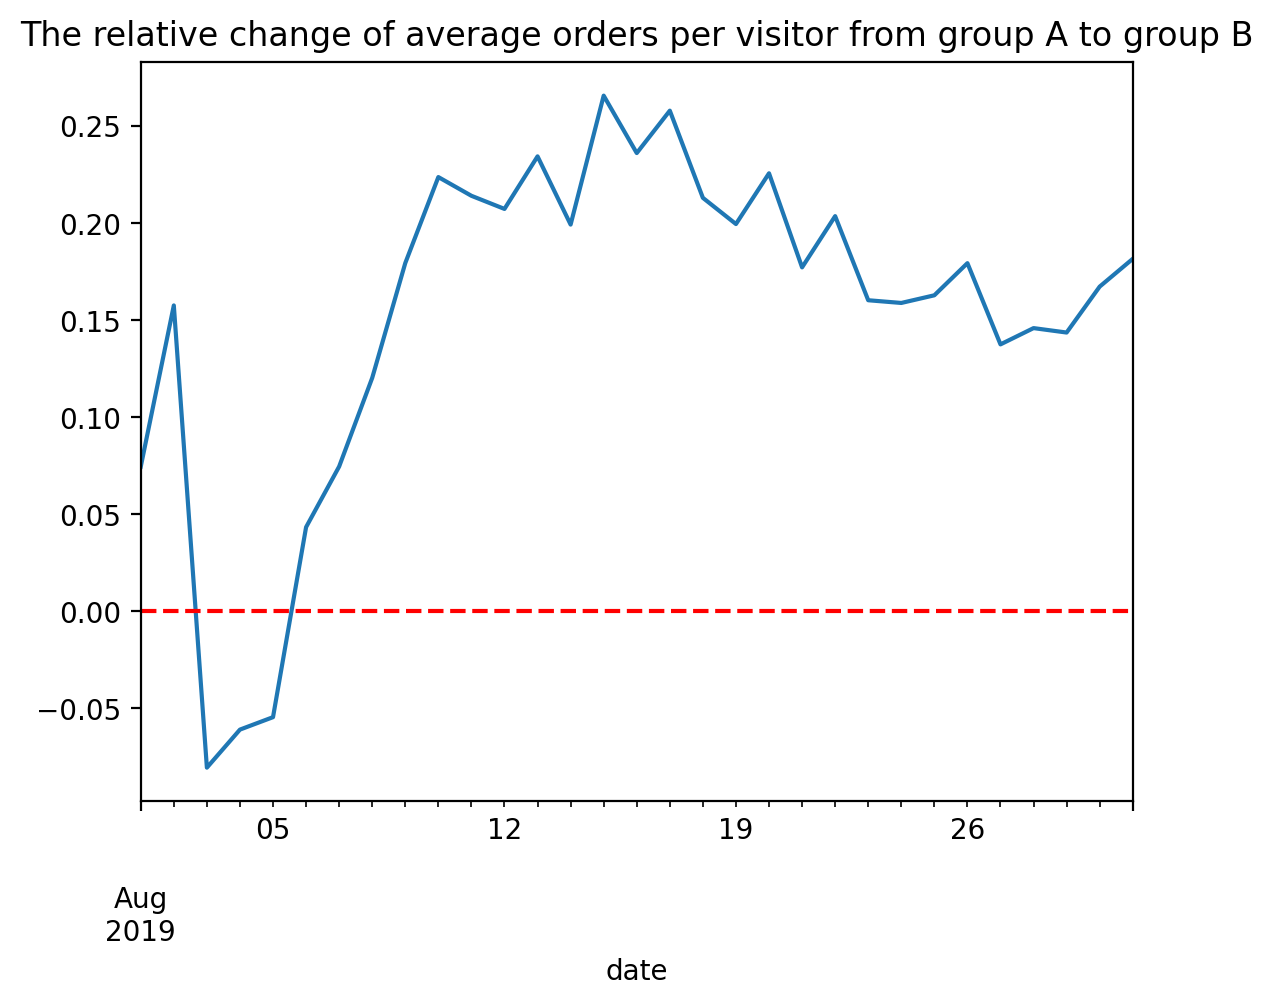

In [106]:
(avg_orders_b / avg_orders_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('The relative change of average orders per visitor from group A to group B');

## Statistical analysis

#### Average orders per visitor

Preparing samples for analysis

In [107]:
#number of orders for each buyer in group A
raw_sample_a = orders.query('group == "A" and visitor_id not in @filtered_users').groupby('visitor_id')['revenue'].count()
#list of zeroes for those who didn't buy
non_buyers = pd.Series(0, np.arange(0, visitors.query('group == "A"')['visitors'].sum() - len(raw_sample_a)))
#collecting to one sample
sample_a = pd.concat([raw_sample_a, non_buyers])

#same for group В
raw_sample_b = orders.query('group == "B" and visitor_id not in @filtered_users').groupby('visitor_id')['revenue'].count()
non_buyers = pd.Series(0, np.arange(0, visitors.query('group == "B"')['visitors'].sum() - len(raw_sample_b)))
sample_b = pd.concat([raw_sample_b, non_buyers])

Let's use Mann-Whitney U-cryterion, alpha = 0.05.  
  
**Null hypothesis:** there is no statistically significant difference between the samples   
**Alternative Hypothesis:** There is a statistically significant difference between the samples, and sample B has higher values in the distribution than sample A.

In [108]:
st.mannwhitneyu(sample_a, sample_b, alternative='less').pvalue

0.006267882559932594

We reject the null hypothesis in favor of the idea that there is a statistically significant difference between the samples, and group B performs better.  
Let's see how much better.

##### Confidence interval

Let's find analytically.

In [109]:
#точечная оценка
p_est = sample_b.mean() - sample_a.mean()

#стандартные отклонения и размеры выборок
std_a, std_b = sample_a.std(), sample_b.std()
n_a, n_b = sample_a.shape[0], sample_b.shape[0]

#погрешность
z = st.t.ppf(0.975, n_a + n_b -2)
moe = z * (std_a**2 / n_a + std_b**2 / n_b)**0.5

#интервал в штуках
interval = [p_est - moe, p_est + moe]

#выведем интервал в процентах
'{:.2%}'.format(interval[0] / sample_a.mean()), \
'{:.2%}'.format(interval[1] / sample_a.mean())

('3.99%', '32.31%')

And double-check with bootstrap.

In [110]:
diff_list = []
for i in range(5000):
    a_=np.random.choice(sample_a, len(sample_a), replace=True)
    b_=np.random.choice(sample_b, len(sample_b), replace=True)
    diff = b_.mean() - a_.mean()
    diff_list.append(diff)

interval = np.percentile(diff_list, [2.5, 97.5])

'{:.2%}'.format(interval[0] / sample_a.mean()), \
'{:.2%}'.format(interval[1] / sample_a.mean())

('3.79%', '32.51%')

Pretty close values.  
Final conclusion: we observe a statistically significant difference between groups A and B. With a 95% confidence level, the average number of purchases per visitor for group B is higher by a margin ranging from 4% to 32% compared to group A.

#### Average check per order

Let's check that sample-sizes are close enough to use mann-whitney.

In [111]:
orders.query('group == "A"')['revenue'].shape[0]

430

In [112]:
orders.query('group == "B"')['revenue'].shape[0]

513

This will do.  
  
Just out of curiosity let's check the sample means.

In [113]:
orders.groupby('group')['revenue'].mean()

group
A   5102.51
B   4855.19
Name: revenue, dtype: float64

In [114]:
st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'], alternative='less').pvalue

0.6771379686919401

Average check of group B is lower, but U-cryterion says it's not statistically significant.

## Overall Summary

**Preprocessing:**  
We have A/B testing result data for the entire month of August 2019.  
No preprocessing required - there are no duplicates, empty values, or obvious anomalies in the data.  
The ourliers were removed - about 6% of data for buyers who performed unusual actions, such as making numerous purchases or buying expensive items.

**A/B test reliability evaluation:**  
- The group sizes are approximately equal - everything is fine with the test here.  
- There are about 6% of users who made about 15% of purchases that were placed in both groups. Since this affects the correctness of the A/B test results, the purchases of these users, as well as the visits we know about, have been removed from the `orders` and `visitors` tables, despite being a significant portion of the data.  
- In the visitors table, there may still be visitors incorrectly counted in both groups who did not make purchases at the time of the visit. It is impossible to track this with the available data.

**The results of statistical tests** indicate that:
- There is no statistically significant difference between the groups in the average check per buyer.
- There is a statistically significant difference between the groups in the number of orders per visitor, in favor of group B (with a 95% confidence level, the average number of purchases per visitor for group B is higher by a margin ranging from 4% to 32% compared to group A).  

The result has been rather stable for some time already.

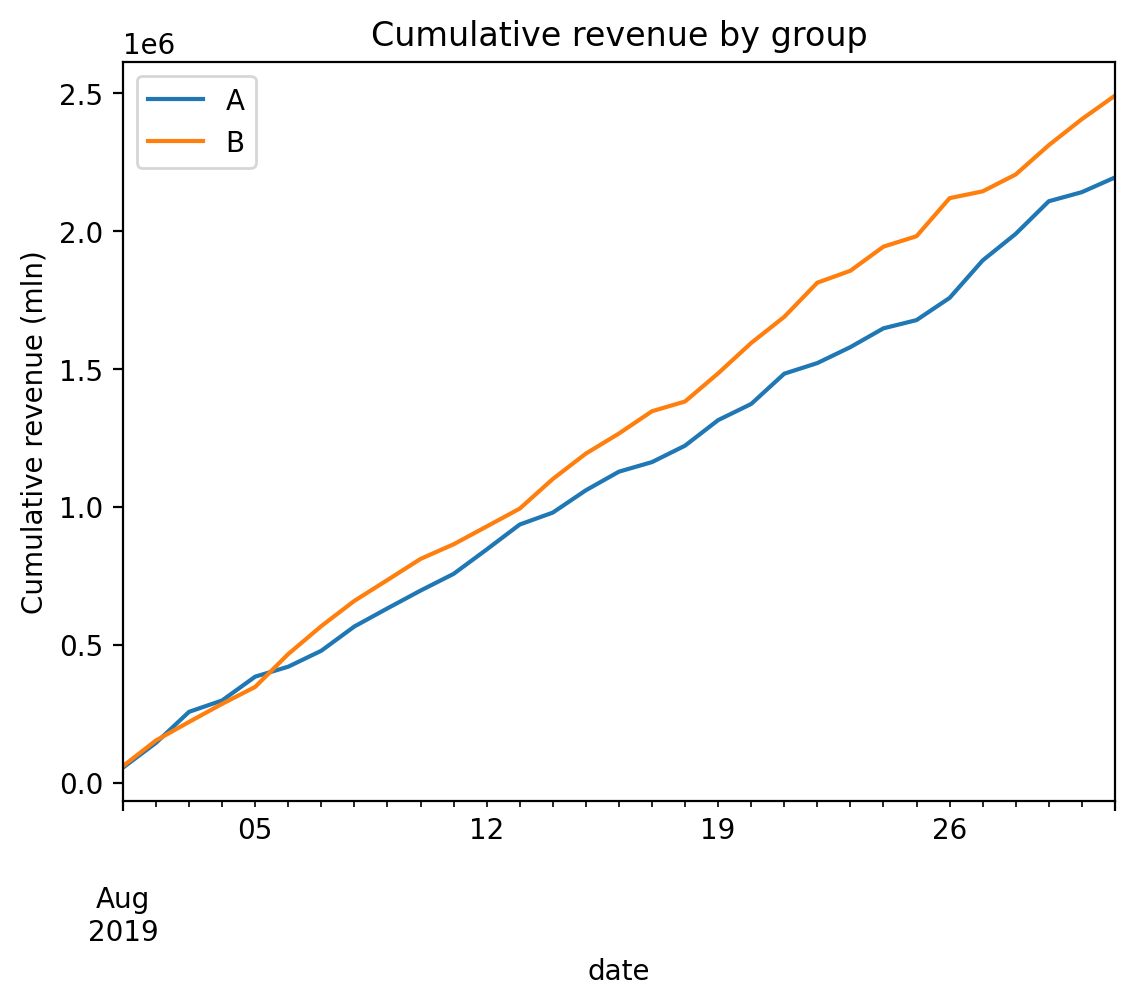

In [115]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Cumulative revenue by group')
plt.ylabel('Cumulative revenue (mln)')
plt.show()

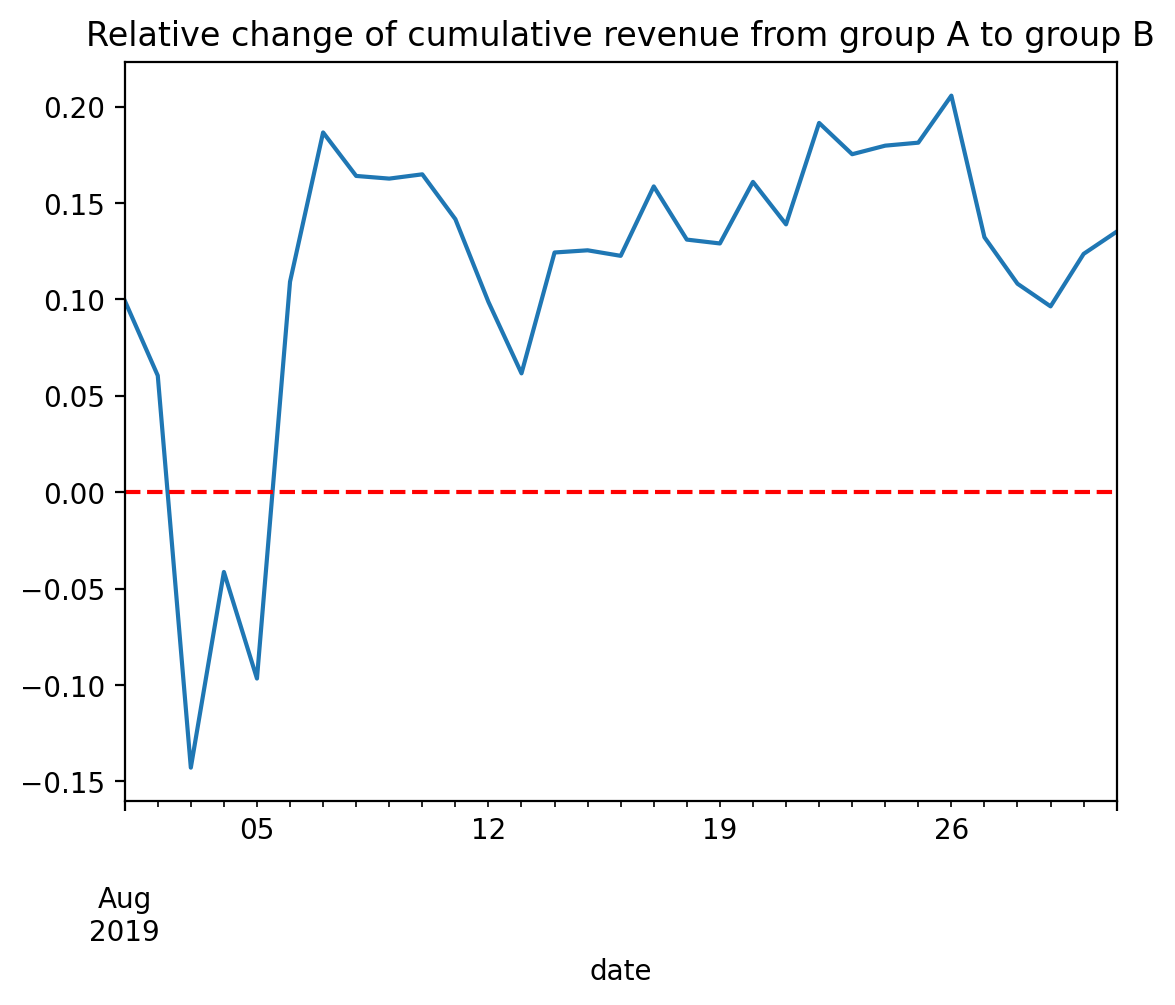

In [116]:
(cum_revenue_b / cum_revenue_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Relative change of cumulative revenue from group A to group B');